# EDA - Hourly data of solar irradiation at three cities in virginia from NSRDB

Author: Huiting Song


In [1]:
# Import packages
import pandas as pd
import sklearn
import numpy as np
import nltk
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [2]:
from codecarbon import EmissionsTracker
experiment_name = "EDA-NSRDB"

tracker = EmissionsTracker(
    output_dir="/Users/crystal/Desktop/ANLY5550/codecarbon",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()

In [3]:
# Read CSV
Arlington = pd.read_csv("/Users/crystal/Desktop/ANLY5550/Data/Cleaned/NSRDB_Arlington_cleaned.csv")
Richmond = pd.read_csv("/Users/crystal/Desktop/ANLY5550/Data/Cleaned/NSRDB_Richmond_cleaned.csv")
Shenandoah = pd.read_csv("/Users/crystal/Desktop/ANLY5550/Data/Cleaned/NSRDB_Shenandoah_cleaned.csv")

Since there are three datasets from three cities in virginia, I want to have a look on the GHI in three cities. Throught combining the GHI data in three cities by date, then I can make comparison and visualization of GHI in three cities from 2019-01-01 to 2023-12-31.

In [4]:
# Extract GHI and date from each dataset
# Rename 'GHI' column to include the city name for clarity when merged
city1 = Arlington[['Date', 'GHI']].rename(columns={'GHI': 'Arlington GHI'}).copy()
city2 = Richmond[['Date', 'GHI']].rename(columns={'GHI': 'Richmond GHI'}).copy()
city3 = Shenandoah[['Date', 'GHI']].rename(columns={'GHI': 'Shenandoah GHI'}).copy()

# Convert 'Date' to datetime in each dataset to ensure consistency
city1['Date'] = pd.to_datetime(city1['Date'])
city2['Date'] = pd.to_datetime(city2['Date'])
city3['Date'] = pd.to_datetime(city3['Date'])

# Merge the datasets on 'Date'
combined_data = pd.merge(city1, city2, on='Date', how='outer')
combined_data = pd.merge(combined_data, city3, on='Date', how='outer')

# Sort the combined data by date
combined_data.sort_values(by='Date', inplace=True)

# Save the combined dataset to a new CSV file
combined_data.to_csv('/Users/crystal/Desktop/ANLY5550/Data/Cleaned/combined_cities_GHI_NSRDB.csv', index=False)

combined_data.head(10)

,Date,Arlington GHI,Richmond GHI,Shenandoah GHI
0,2019-01-01 08:00:00,19,11,18
1,2019-01-01 09:00:00,66,9,74
2,2019-01-01 10:00:00,54,15,179
3,2019-01-01 11:00:00,182,71,139
4,2019-01-01 12:00:00,187,151,175
5,2019-01-01 13:00:00,187,193,220
6,2019-01-01 14:00:00,190,120,96
7,2019-01-01 15:00:00,134,148,146
8,2019-01-01 16:00:00,42,44,69
9,2019-01-02 08:00:00,20,17,18


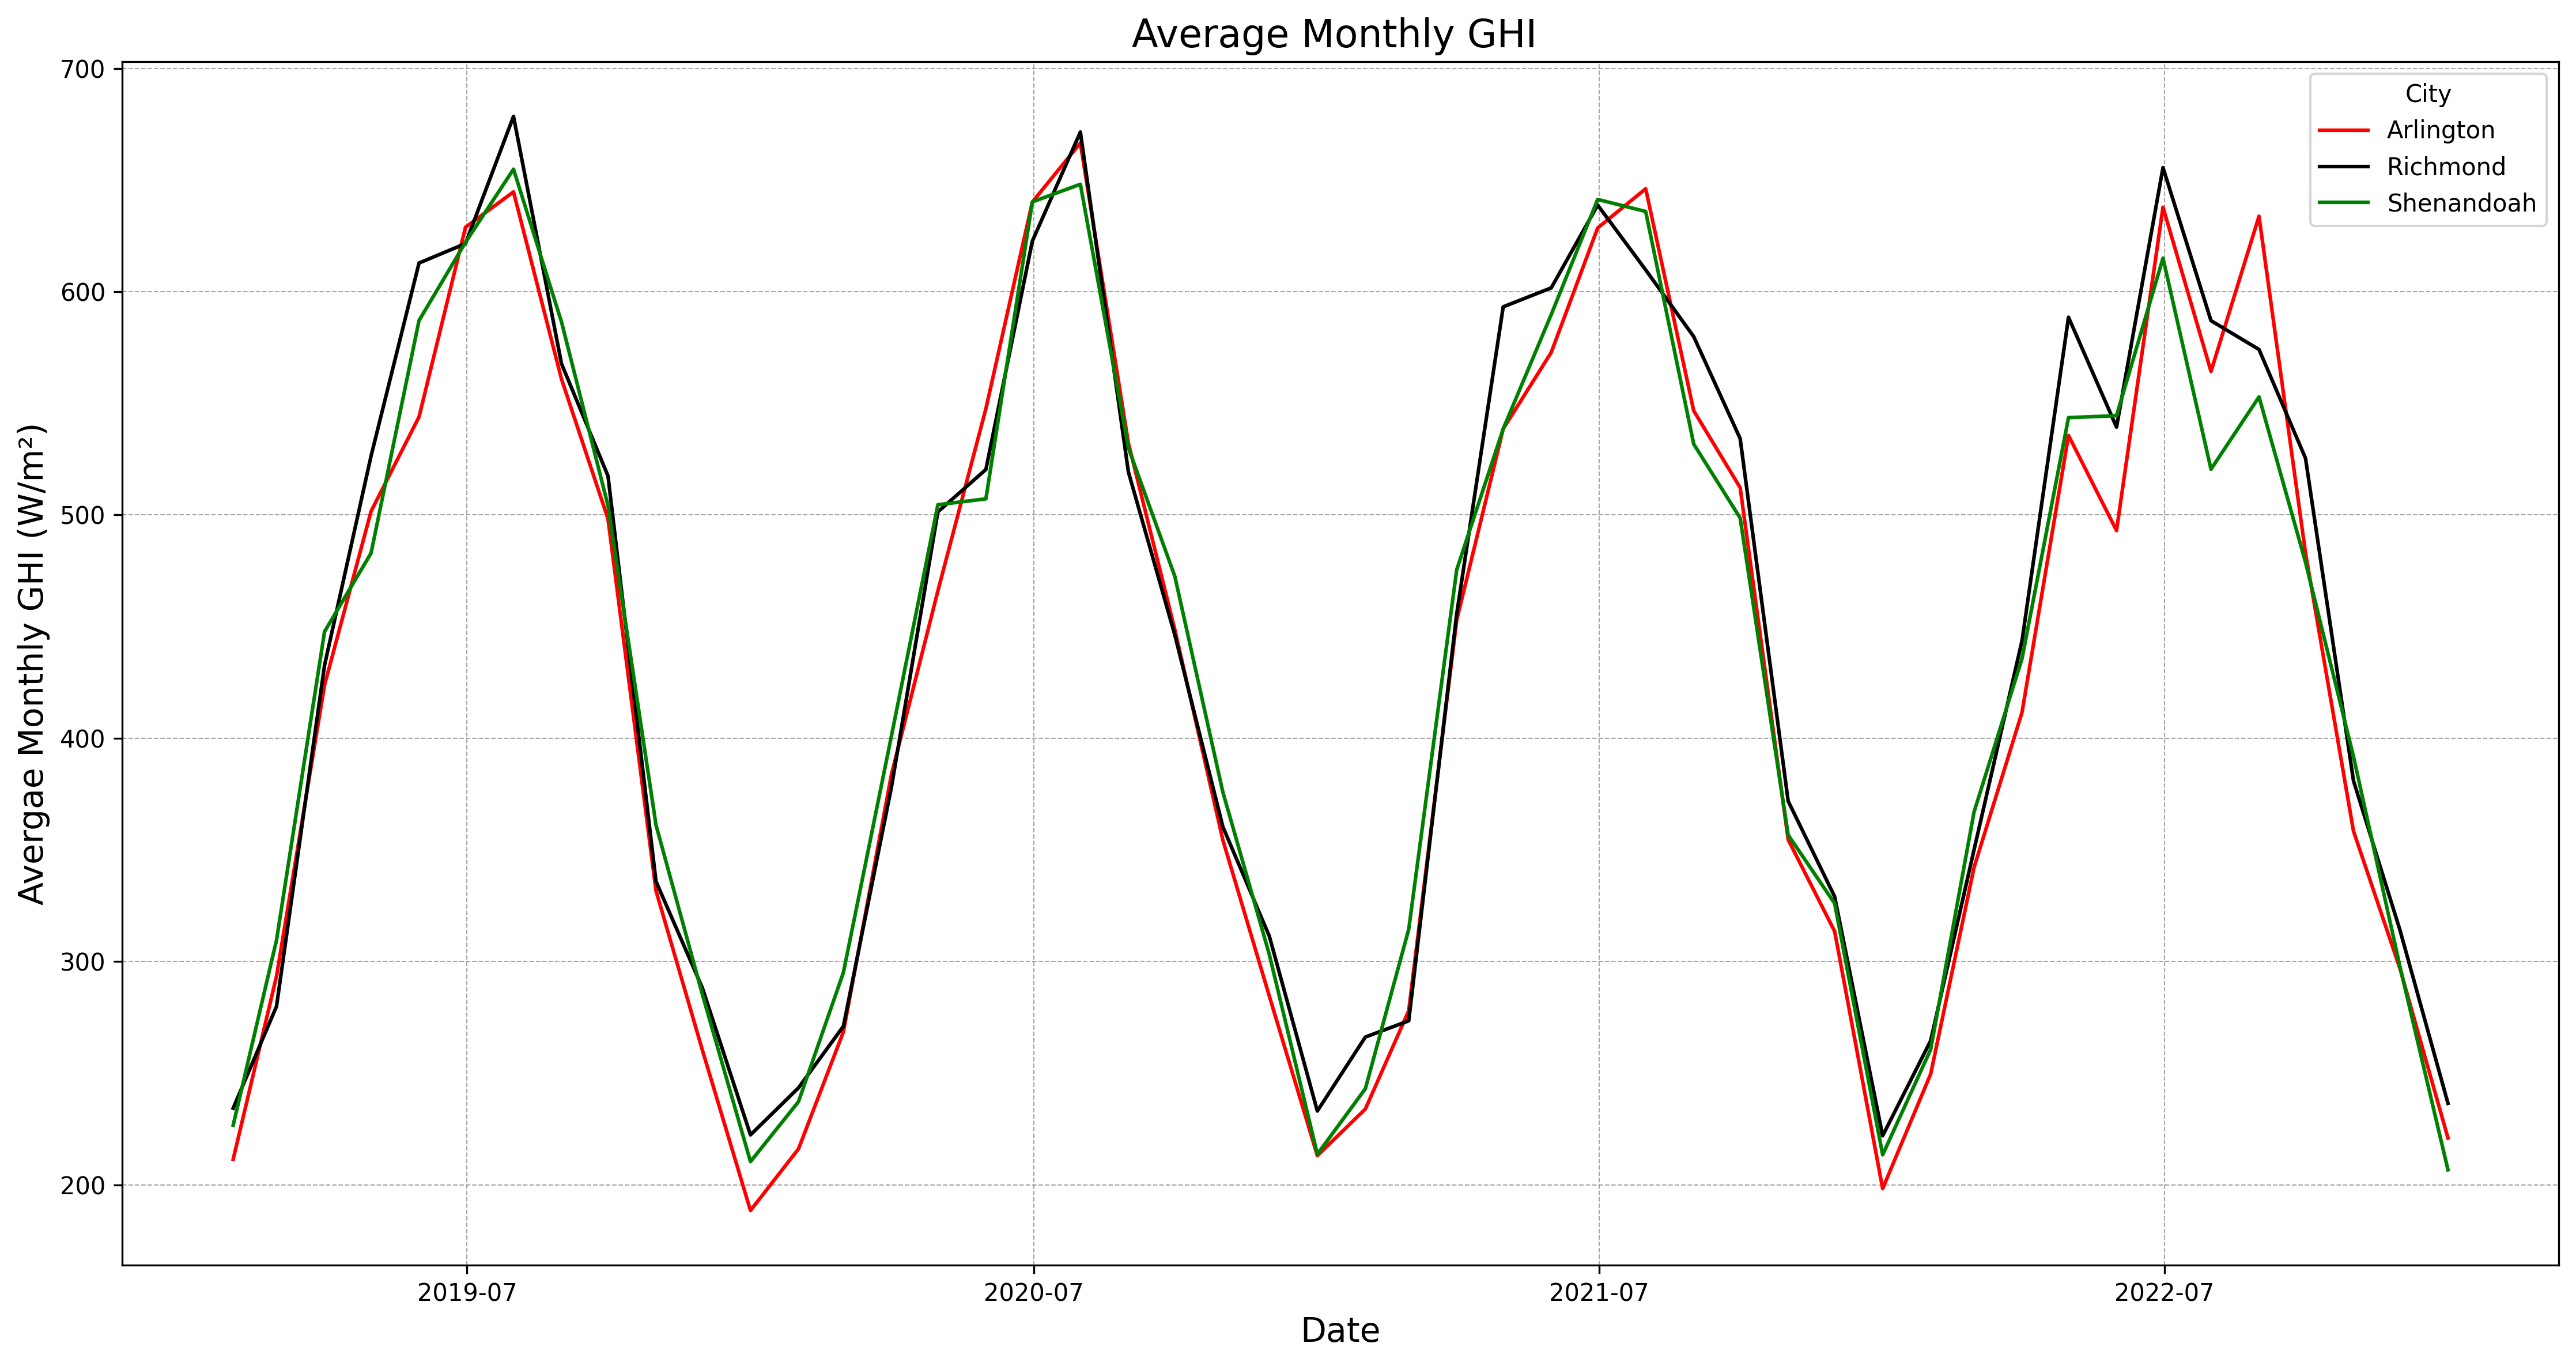

In [5]:
# Convert 'Date' column to datetime if it's not already
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

# Set 'Date' as the index for resampling
combined_data.set_index('Date', inplace=True)

# Resample data to monthly averages
monthly_data = combined_data.resample('M').mean().reset_index()

# Plot setup
plt.figure(figsize=(15, 8), dpi=300)

# Plot the monthly mean GHI for each city
sns.lineplot(x='Date', y='Arlington GHI', data=monthly_data, label='Arlington',color='red')
sns.lineplot(x='Date', y='Richmond GHI', data=monthly_data, label='Richmond',color='black')
sns.lineplot(x='Date', y='Shenandoah GHI', data=monthly_data, label='Shenandoah',color='green')

# Enhance grid readability
plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey', alpha=0.7)

# Formatting the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# Choose an appropriate tick interval so that the x-axis is readable
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))

# Add labels, title, and legend
plt.xlabel('Date', fontsize=14)
plt.ylabel('Avergae Monthly GHI (W/m²)', fontsize=14)
plt.title('Average Monthly GHI ', fontsize=16)
plt.legend(title='City')

# Adjust the plot layout to fit the x-axis labels and title
plt.tight_layout()

# Save the plot as a high-resolution PNG file
plt.savefig('/Users/crystal/Desktop/ANLY5550/Visualization/GHI_three_cities.png', format='png')

plt.show()

### Arlington

In [6]:
Arlington.head(10)

,Date,GHI,Temperature,Cloud Type,Dew Point,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,2019-01-01 08:00:00,19,12.6,7,10.6,0.236,87.40,85.22,0.07,1006,1.3,282,5.3
1,2019-01-01 09:00:00,66,12.3,7,9.7,0.238,84.06,76.37,0.07,1008,1.3,288,5.2
2,2019-01-01 10:00:00,54,12.0,6,8.9,0.241,81.25,69.11,0.07,1009,1.2,295,5.3
3,2019-01-01 11:00:00,182,11.4,6,7.9,0.243,79.14,64.10,0.07,1009,1.1,302,5.3
4,2019-01-01 12:00:00,187,11.2,6,7.3,0.247,77.11,61.91,0.07,1009,1.0,305,5.1
5,2019-01-01 13:00:00,187,11.7,6,7.2,0.249,73.73,62.86,0.07,1010,1.0,310,5.0
6,2019-01-01 14:00:00,190,11.8,6,6.9,0.248,72.16,66.81,0.07,1010,1.0,315,4.7
7,2019-01-01 15:00:00,134,11.0,6,6.8,0.249,75.49,73.25,0.07,1012,1.0,319,4.0
8,2019-01-01 16:00:00,42,9.0,6,6.4,0.251,83.59,81.55,0.07,1013,1.1,323,2.9
9,2019-01-02 08:00:00,20,3.7,7,2.5,0.268,92.18,85.23,0.06,1020,1.1,64,0.9


In [7]:
# Cloud type is categorical variables
Arlington['Cloud Type'].unique() # total 9 types of cloud in the dataset

array([7, 6, 4, 0, 8, 1, 2, 9, 3, 5])

In [8]:
# Convert 'Cloud Type' to a categorical variable
Arlington['Cloud Type'] = pd.Categorical(Arlington['Cloud Type'])

In [9]:
# Summary Statistics
Arlington.describe()

,GHI,Temperature,Dew Point,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed
count,13140.000000,13140.000000,13140.000000,13140.000000,13140.00000,13140.000000,13140.000000,13140.000000,13140.000000,13140.000000,13140.000000
mean,429.961187,17.345860,9.072542,0.309142,61.07714,51.780851,0.123966,1010.998402,2.268798,210.539193,2.944726
std,274.989093,10.617656,9.254981,0.032860,17.38866,17.142895,0.091051,7.194148,1.422819,96.140010,1.512662
min,3.000000,-13.000000,-20.100000,0.213000,18.16000,15.610000,0.050000,977.000000,0.100000,0.000000,0.100000
25%,184.000000,8.300000,1.400000,0.288000,47.40750,39.150000,0.100000,1006.000000,1.000000,148.000000,1.800000
50%,424.000000,18.100000,9.950000,0.306000,59.43500,53.880000,0.110000,1011.000000,2.000000,218.000000,2.700000
75%,651.000000,26.500000,17.200000,0.327000,74.04250,64.020000,0.130000,1016.000000,3.300000,295.000000,3.800000
max,1035.000000,37.800000,25.600000,0.463000,100.00000,85.240000,0.800000,1035.000000,6.500000,360.000000,9.700000


#### Visualization of Target Variables GHI 

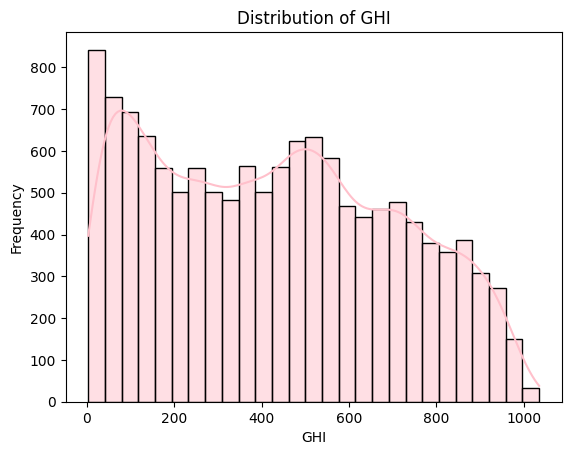

In [10]:
# Distribution of GHI
sns.histplot(Arlington['GHI'], kde=True,color='pink')
plt.title('Distribution of GHI')
plt.xlabel('GHI')
plt.ylabel('Frequency')
plt.show()

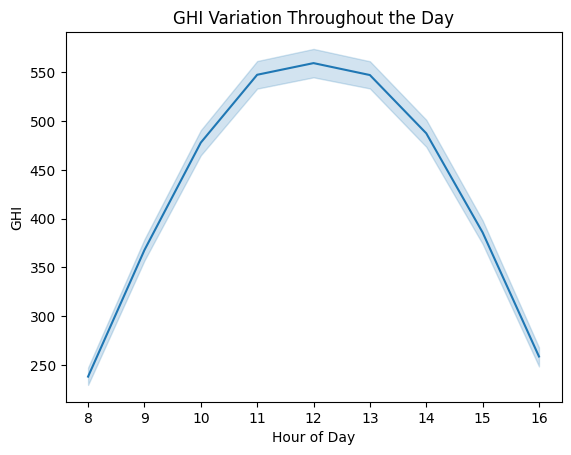

In [11]:
# Temporal patterns: GHI throughout the day
Arlington['Date'] = pd.to_datetime(Arlington['Date'])

sns.lineplot(x=Arlington['Date'].dt.hour, y='GHI', data=Arlington)
plt.title('GHI Variation Throughout the Day')
plt.xlabel('Hour of Day')
plt.ylabel('GHI')
plt.show()

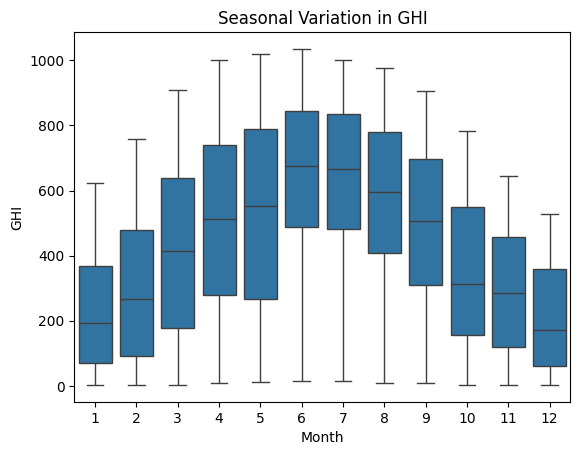

In [12]:
# Seasonal variation in GHI
sns.boxplot(x=Arlington['Date'].dt.month, y='GHI', data=Arlington)
plt.title('Seasonal Variation in GHI')
plt.xlabel('Month')
plt.ylabel('GHI')
plt.show()

#### Feature Selection

/var/folders/44/9f70kzrs4hd1xjzn2ldh0hqh0000gn/T/ipykernel_50463/542926835.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = Arlington.corr()


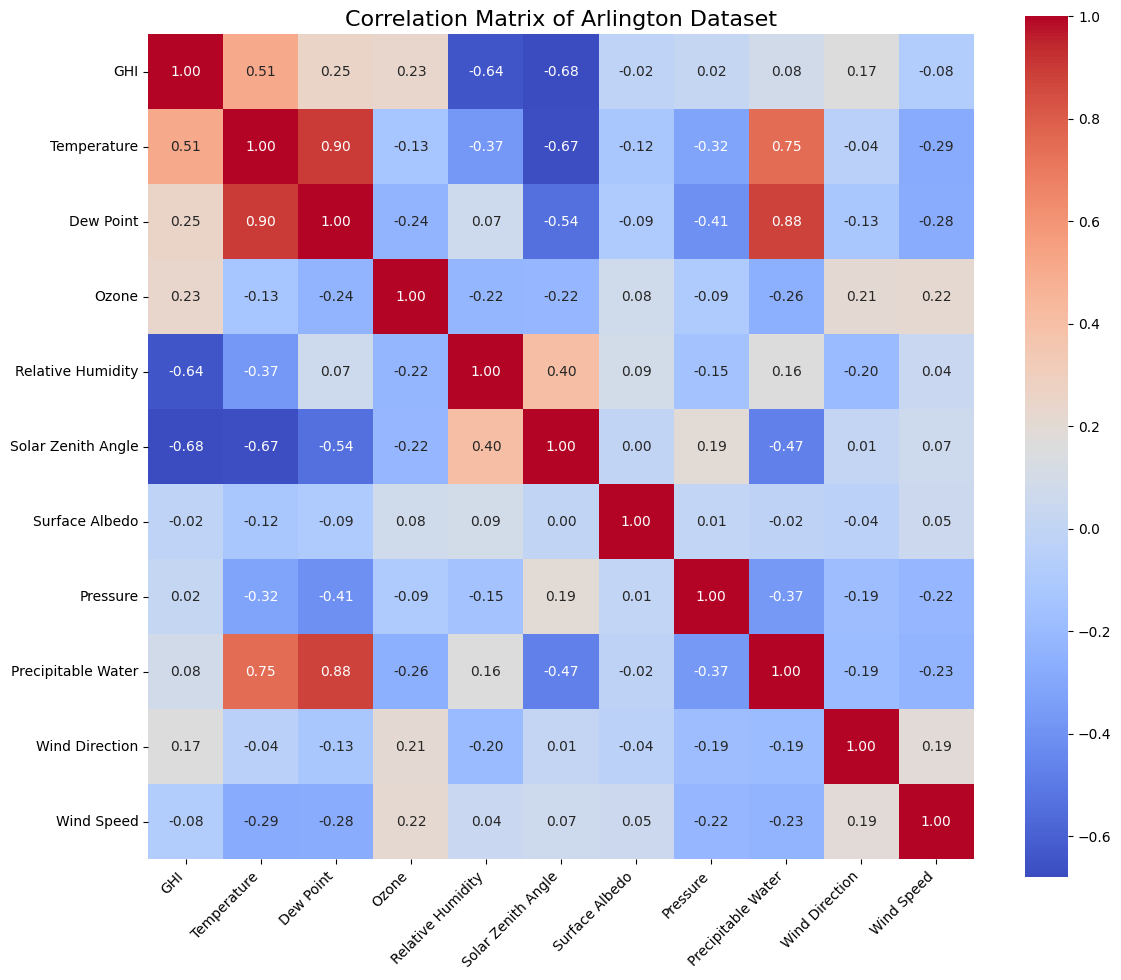

In [13]:
# correlation matrix
corr_matrix = Arlington.corr()

plt.figure(figsize=(12, 10))  
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, 
            annot_kws={'size': 10}, square=True)

plt.title('Correlation Matrix of Arlington Dataset', fontsize=16)  
plt.xticks(fontsize=10, rotation=45, ha='right')  
plt.yticks(fontsize=10, rotation=0)  
plt.tight_layout()  

# Optionally, save the figure to a file
plt.savefig('/Users/crystal/Desktop/ANLY5550/Visualization/heatmap_Arlington.png', format='png', dpi=300)  # Save as a high-resolution image

plt.show()

`GHI and Relative Humidity`: There is a strong negative correlation between GHI and relative humidity. This is expected because high humidity often comes with cloud cover, which reduces solar radiation.<p>
`GHI and Solar Zenith Angle`: There is a similarly strong negative correlation between GHI and the solar zenith angle. The larger the angle (further from directly overhead), the less solar radiation hits the earth's surface directly, hence lower GHI.<p>
`GHI and Temperature`: There's a moderate negative correlation with temperature, which might seem counterintuitive since we associate sunny days with higher temperatures. However, this might reflect times of the day when despite high temperatures, the solar zenith angle is high, or there is significant cloud cover.<p>
`Dew Point`: There is a moderate positive correlation with dew point, which could suggest that higher dew points (indicative of more moisture in the air) are associated with times when GHI is higher, possibly during certain seasons or times of day.<p>
`Pressure`: Pressure shows a very weak positive correlation with GHI, suggesting that changes in atmospheric pressure don't have a significant direct impact on GHI measurements.<p>
`Wind Direction and Wind Speed`: These have low to negligible correlations with GHI, indicating that they don't have a strong direct influence on solar irradiance levels.<p>
`Ozone`: There's a very weak correlation with ozone. While ozone high in the atmosphere protects us from UV radiation, its variations at ground level don't seem to have a significant impact on GHI.<p>
`Precipitable Water`: This shows a weak to moderate positive correlation with GHI, which may reflect regional or seasonal patterns where sunnier days can also be more humid.<p>

In [14]:
# Separate features and target
X = Arlington.drop(['GHI', 'Date'], axis=1)  # Exclude 'Date' for feature selection, and 'GHI' is the target
y = Arlington['GHI']

# Let's assume "Cloud Type" is a categorical column that you want to one-hot encode.
categorical_features = ['Cloud Type']
continuous_features = X.columns.difference(categorical_features).tolist()

# One-hot encode the categorical features only
column_trans = ColumnTransformer(
    [('categorical', OneHotEncoder(), categorical_features)],
    remainder='passthrough'
)

X_encoded = column_trans.fit_transform(X)

# Split the data back into categorical and continuous features after transformation
X_categorical = X_encoded[:, :X_encoded.shape[1]-len(continuous_features)]
X_continuous = X_encoded[:, X_encoded.shape[1]-len(continuous_features):]

# Apply SelectKBest with chi2 to the categorical features
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X_categorical, y)
chi2_scores = chi2_selector.scores_

# Apply SelectKBest with f_regression to the continuous features
f_selector = SelectKBest(score_func=f_regression, k='all')
f_selector.fit(X_continuous, y)
f_scores = f_selector.scores_

# Combine the scores into one array
scores = np.concatenate((chi2_scores, f_scores))

# Combine the p-values into one array
p_values = np.concatenate((chi2_selector.pvalues_, f_selector.pvalues_))

# Combine names
feature_names = column_trans.named_transformers_['categorical'].get_feature_names_out().tolist() + continuous_features

# Create a DataFrame for display
feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'Score': scores,
    'p-value': p_values,
})

print(feature_scores.sort_values(by='Score', ascending=False))

               Feature         Score        p-value
14   Relative Humidity  11328.676273   0.000000e+00
13            Pressure   9254.063704   0.000000e+00
10           Dew Point   4697.942877   0.000000e+00
6         Cloud Type_6   2601.665261  3.644307e-140
0         Cloud Type_0   2532.650070  4.500855e-131
4         Cloud Type_4   1672.417158   3.341616e-35
1         Cloud Type_1   1400.484222   5.830667e-15
2         Cloud Type_2   1114.607206   1.387764e-02
3         Cloud Type_3   1093.516654   3.935482e-02
8         Cloud Type_8    999.196341   6.153336e-01
7         Cloud Type_7    997.433755   6.303527e-01
9         Cloud Type_9    982.471108   7.486791e-01
11               Ozone    910.705356  1.706600e-193
5         Cloud Type_5    820.190901   9.999976e-01
12  Precipitable Water    763.131707  2.480445e-163
18      Wind Direction    368.527899   5.017987e-81
17         Temperature     90.846218   1.821819e-21
19          Wind Speed     85.475668   2.702659e-20
16      Surf

In [15]:
# Encoding 'Cloud Type' since it's categorical
label_encoder = LabelEncoder()
Arlington['Cloud Type Encoded'] = label_encoder.fit_transform(Arlington['Cloud Type'])

# Features and target
X = Arlington.drop(['GHI', 'Date', 'Cloud Type'], axis=1)  # Drop original 'Cloud Type' and 'Date'
y = Arlington['GHI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Get feature importances
feature_importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame for display
feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df)


Mean Squared Error: 8326.572369051242
               Feature  Importance
4   Solar Zenith Angle    0.492913
10  Cloud Type Encoded    0.346193
3    Relative Humidity    0.063733
7   Precipitable Water    0.017497
0          Temperature    0.015999
8       Wind Direction    0.015753
2                Ozone    0.012379
9           Wind Speed    0.010967
1            Dew Point    0.010268
6             Pressure    0.010138
5       Surface Albedo    0.004160


In [16]:
# Define a dictionary of models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'DecisionTree': DecisionTreeRegressor(),
    'GradientBoosting1': GradientBoostingRegressor(n_estimators=100),
    'GradientBoosting2': GradientBoostingRegressor(n_estimators=200),
    'GradientBoosting3': GradientBoostingRegressor(n_estimators=50),
    'XGBoost1': XGBRegressor(n_estimators=100), 
    'XGBoost2': XGBRegressor(n_estimators=200), 
    'XGBoost3': XGBRegressor(n_estimators=50), 
    'SVM': SVR(kernel='rbf')
}

# Train and evaluate each model
for name, model in models.items():
    # Split the data (assuming you have your DataFrame 'df' ready)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f'{name} Mean Squared Error:', mse)

LinearRegression Mean Squared Error: 19465.435554269534
Ridge Mean Squared Error: 19464.62622035126
Lasso Mean Squared Error: 19463.37893086401
ElasticNet Mean Squared Error: 19572.83572450619
DecisionTree Mean Squared Error: 15479.786910197869
GradientBoosting1 Mean Squared Error: 9024.11493666642
GradientBoosting2 Mean Squared Error: 8598.360364678645
GradientBoosting3 Mean Squared Error: 9969.905286108718
XGBoost1 Mean Squared Error: 8517.457529819185
XGBoost2 Mean Squared Error: 8591.671390215583
XGBoost3 Mean Squared Error: 8315.421850953911
SVM Mean Squared Error: 71507.71241784265


**Observation:** It looks like the Gradient Boosting and XGBoost models have the lowest mean squared error (MSE), indicating better performance compared to the other models. SVM has the highest MSE, suggesting it might not be the best choice for this dataset. Then, we will find the best tree for XGboost which performs better than gradient boosting to find the best performence MSE.

In [17]:
# Initialize the model
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)

# Fit the model with early stopping
xgb_model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_test, y_test)], verbose=False)

# Check the best number of trees built
print("Best number of trees:", xgb_model.best_iteration)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

/Users/crystal/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best number of trees: 291
Mean Squared Error: 7867.453534987251


Mean Squared Error:  7870.708461814653
Mean Squared Error: 7870.708461814653
               Feature  Importance
10  Cloud Type Encoded    0.395522
4   Solar Zenith Angle    0.380591
3    Relative Humidity    0.101394
7   Precipitable Water    0.021899
8       Wind Direction    0.018521
5       Surface Albedo    0.018226
0          Temperature    0.015821
6             Pressure    0.012773
1            Dew Point    0.012697
9           Wind Speed    0.011569
2                Ozone    0.010987


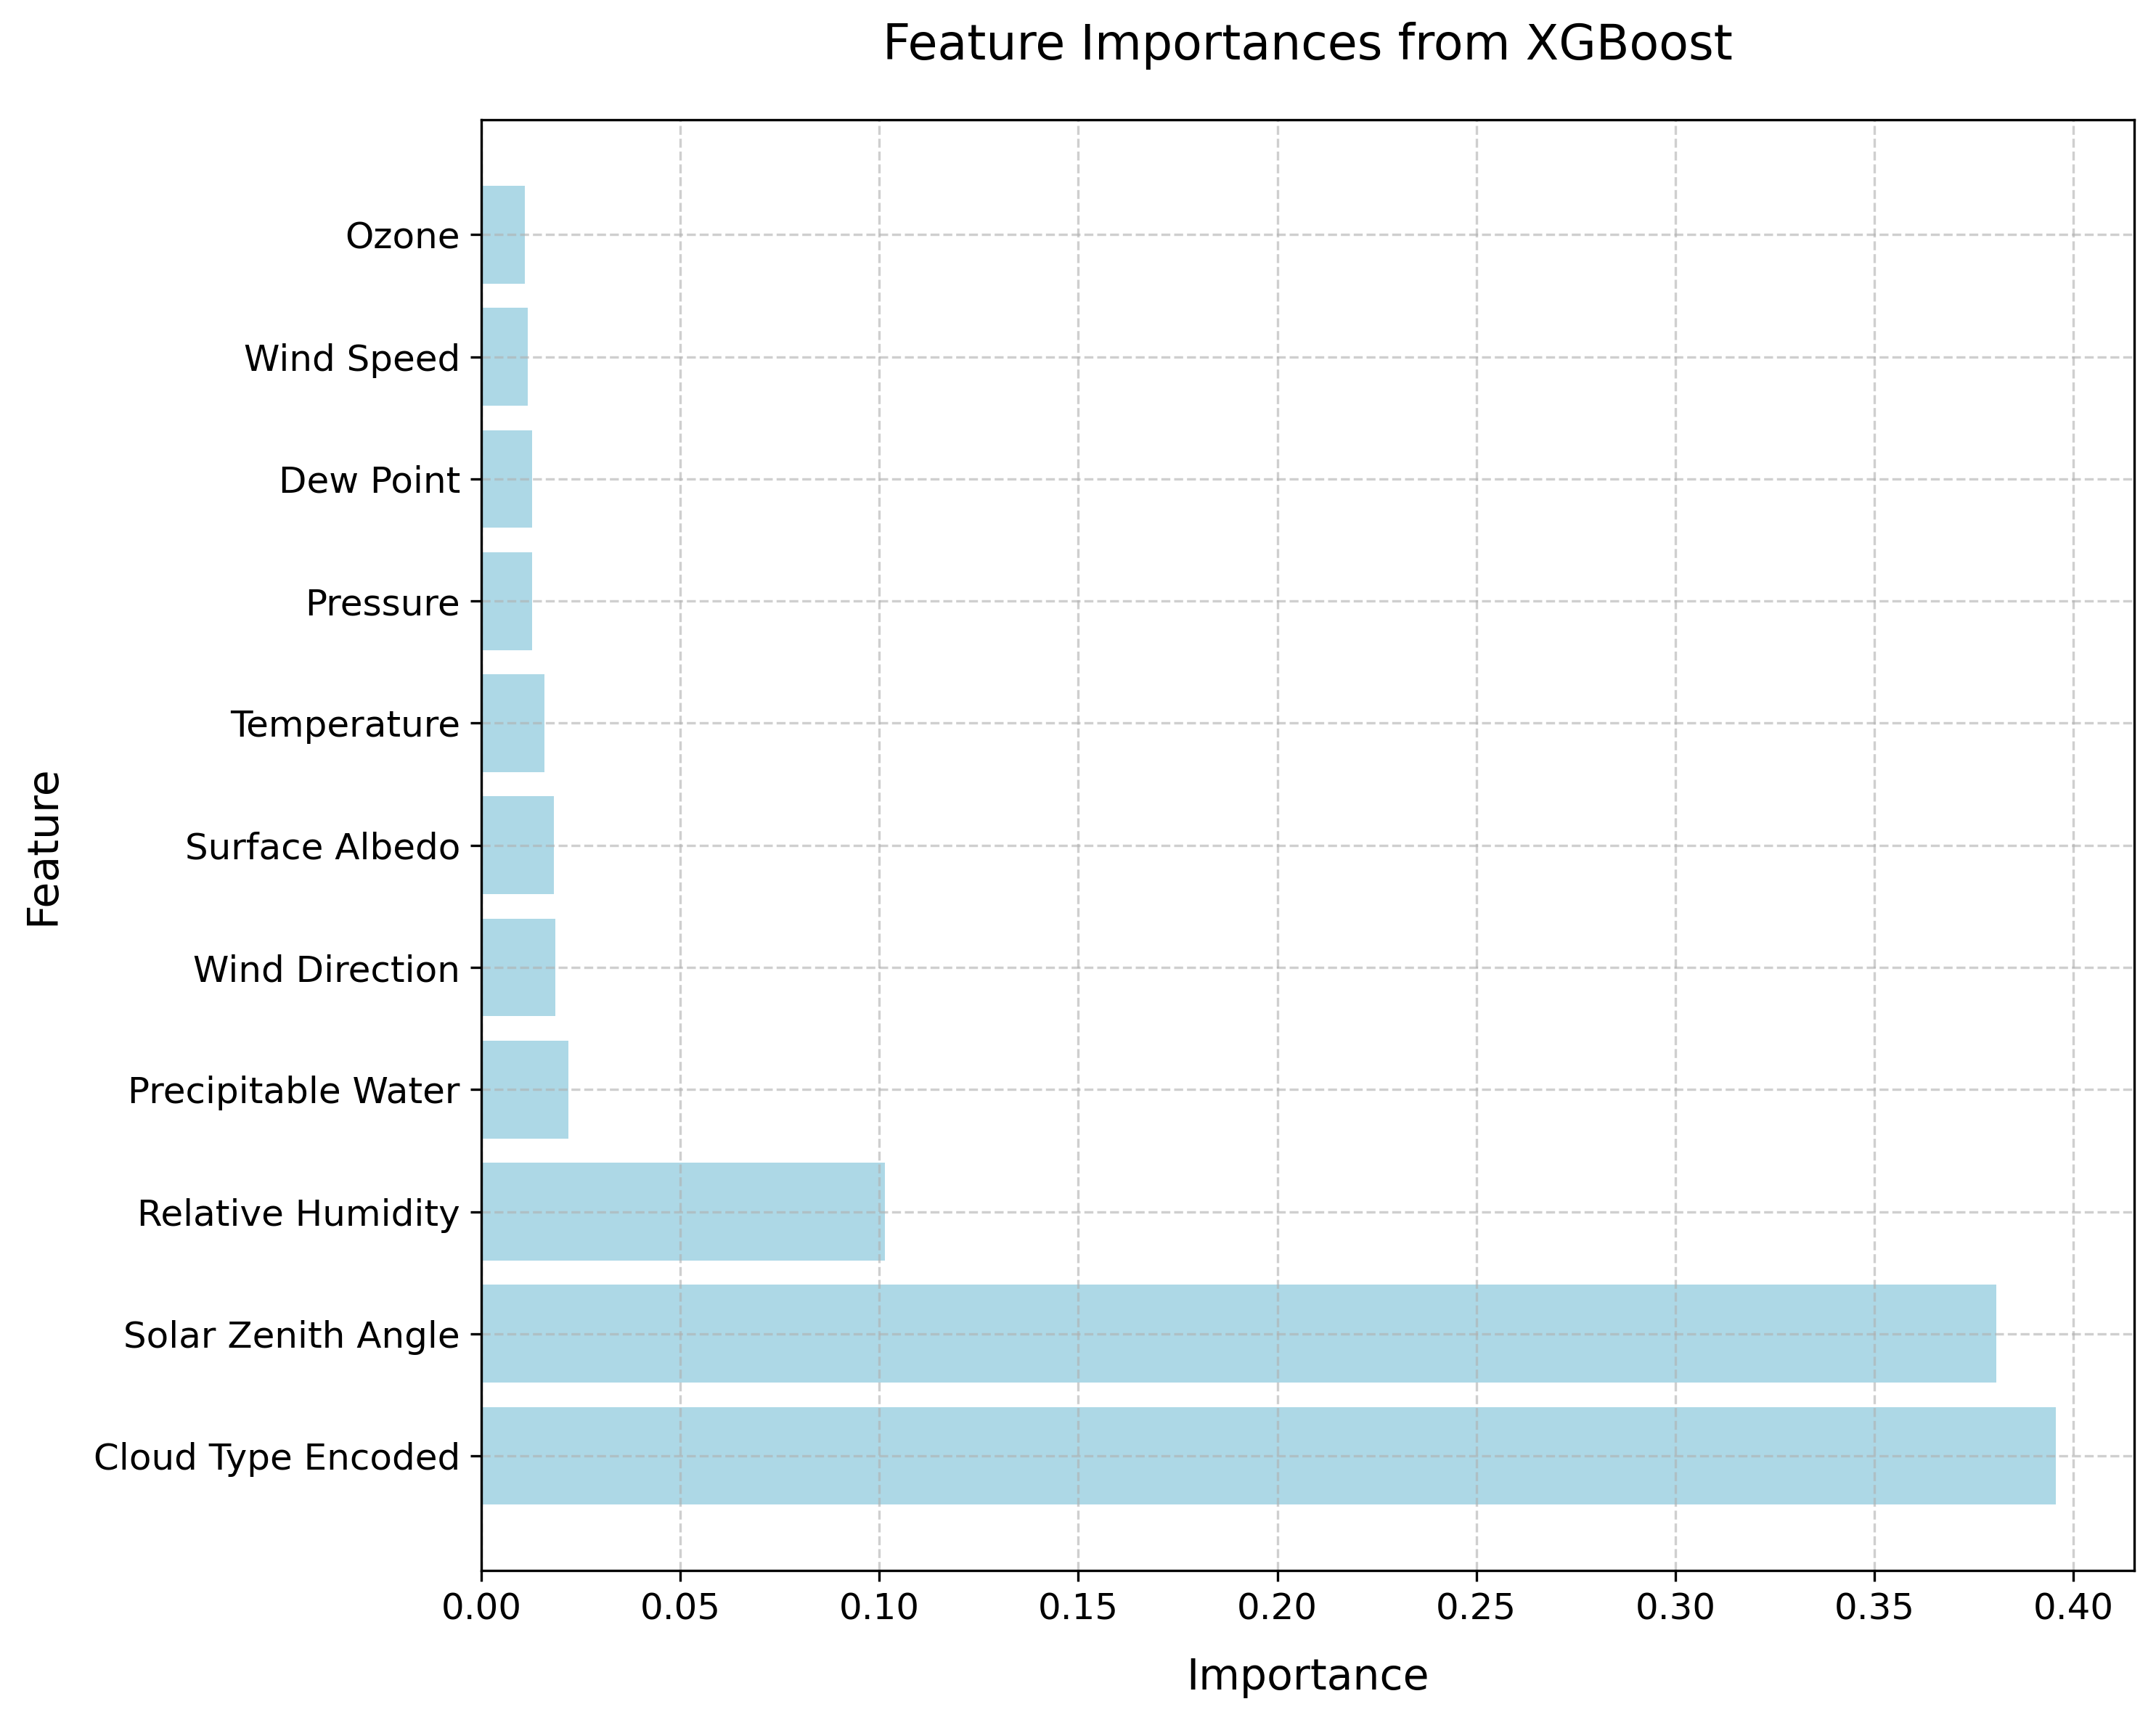

In [18]:
# Initialize the model with best number of tree 291
model = XGBRegressor(n_estimators=291, learning_rate=0.05, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions to evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Get feature importances from the correct model
feature_importances = model.feature_importances_

# Visualize or print feature importances
import pandas as pd
import matplotlib.pyplot as plt

features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(features_df)

# plotting
plt.figure(figsize=(10, 8), dpi=300)  
plt.barh(features_df['Feature'], features_df['Importance'], color='lightblue')  
plt.xlabel('Importance', fontsize=14, labelpad=10)  
plt.ylabel('Feature', fontsize=14, labelpad=10)
plt.title('Feature Importances from XGBoost', fontsize=16, pad=20)  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  

# Adding a tight layout to ensure no part of the labels/titles is cut off
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('/Users/crystal/Desktop/ANLY5550/Visualization/feature_importances.png', format='png', bbox_inches='tight')  
plt.show()


In [19]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=XGBRegressor(n_estimators=291, random_state=42),
                           param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8}
Best score: 7365.867028649326


Final Mean Squared Error: 7819.895503168495
               Feature  Importance
4   Solar Zenith Angle    0.378178
10  Cloud Type Encoded    0.359603
3    Relative Humidity    0.108716
7   Precipitable Water    0.027766
0          Temperature    0.026727
5       Surface Albedo    0.022199
8       Wind Direction    0.020840
1            Dew Point    0.015458
6             Pressure    0.014189
2                Ozone    0.013273
9           Wind Speed    0.013051


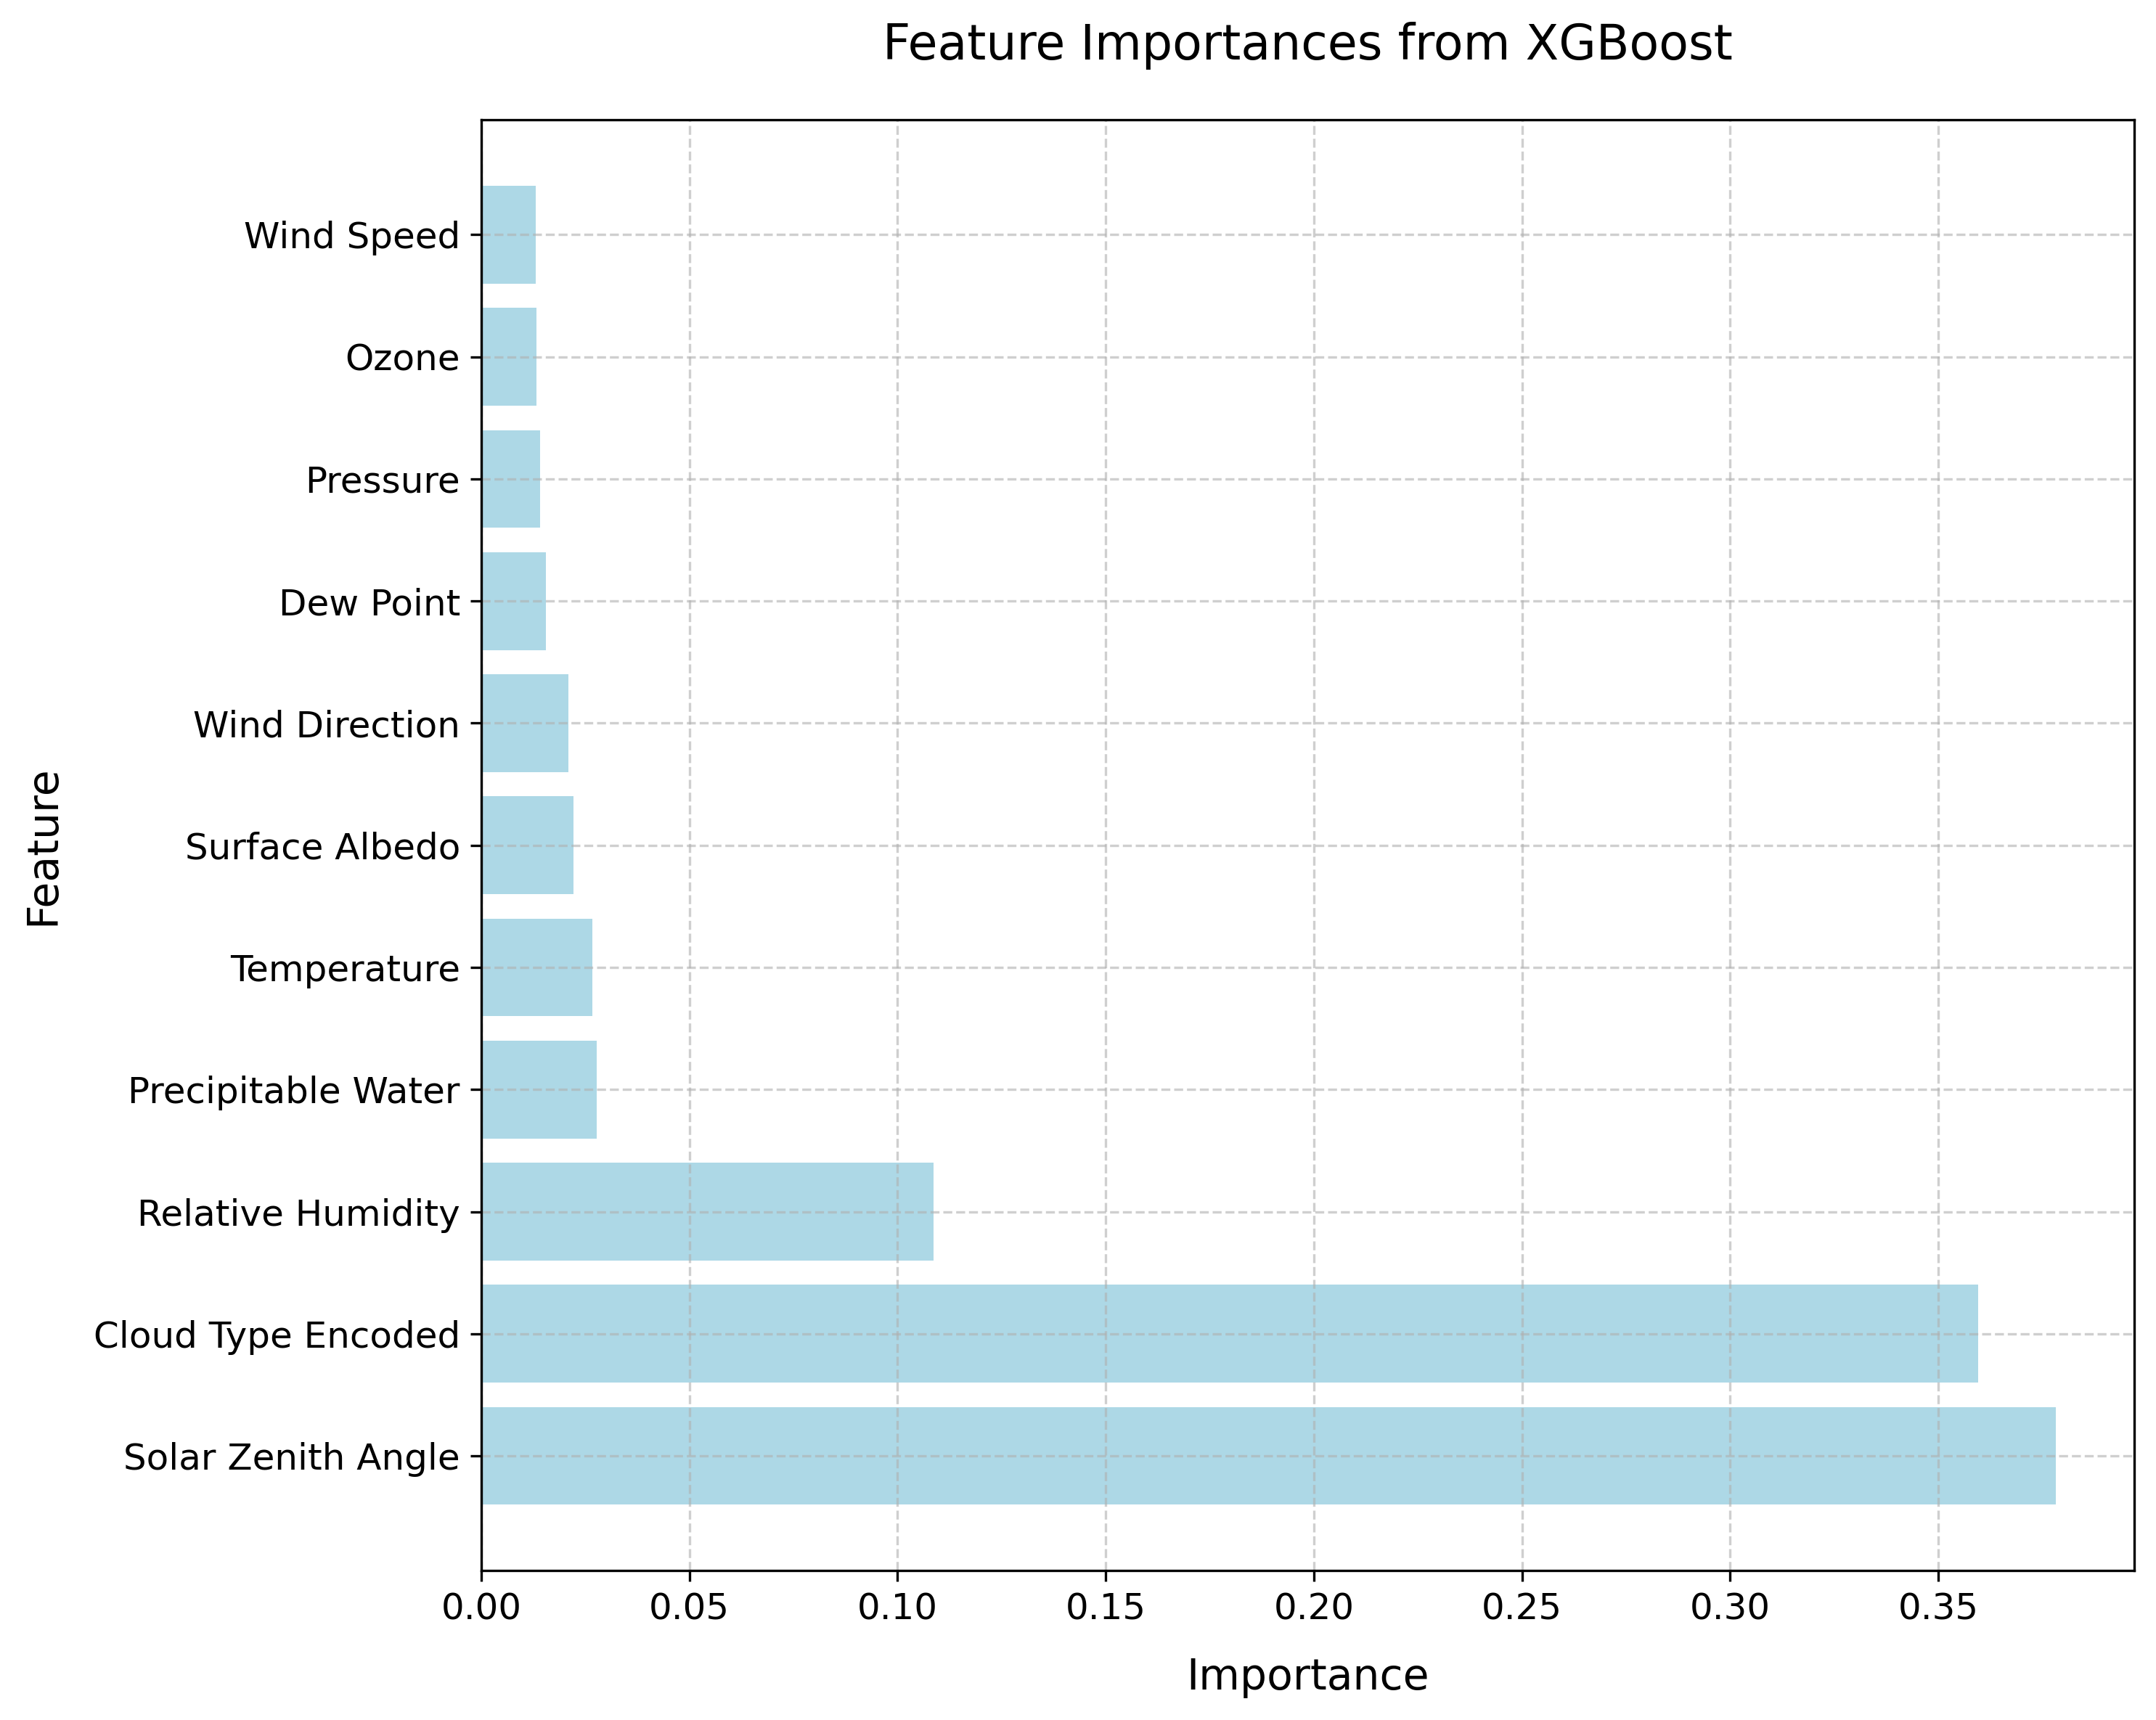

In [20]:
final_model = XGBRegressor(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=2,
    subsample=0.8,
    n_estimators=291,
    random_state=42
)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)
print("Final Mean Squared Error:", final_mse)

feature_importances = final_model.feature_importances_
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(features_df)

# plotting
plt.figure(figsize=(10, 8), dpi=300)  
plt.barh(features_df['Feature'], features_df['Importance'], color='lightblue')  
plt.xlabel('Importance', fontsize=14, labelpad=10)  
plt.ylabel('Feature', fontsize=14, labelpad=10)
plt.title('Feature Importances from XGBoost', fontsize=16, pad=20)  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  

# Adding a tight layout to ensure no part of the labels/titles is cut off
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('/Users/crystal/Desktop/ANLY5550/Visualization/feature_importances.png', format='png', bbox_inches='tight')  
plt.show()


#### prediction

In [21]:
# Convert date column to datetime
Arlington['Date'] = pd.to_datetime(Arlington['Date'])

# Extract time features
Arlington['Hour'] = Arlington['Date'].dt.hour
Arlington['Month'] = Arlington['Date'].dt.month
Arlington['DayOfYear'] = Arlington['Date'].dt.dayofyear

# Optionally, add lagged features if historical GHI values are helpful
Arlington['GHI_lag1'] =Arlington['GHI'].shift(1)

# Fill any resulting NA values
Arlington = Arlington.fillna(method='bfill')

# Define your features and target variable
X = Arlington[['Solar Zenith Angle', 'Cloud Type Encoded', 'Relative Humidity', 'Hour', 'Month', 'DayOfYear', 'GHI_lag1']]
y = Arlington['GHI']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [22]:
# Train the model
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)

# Calculate MSE to evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 9234.709872212194


In [23]:
# Generate future dates
future_dates = pd.date_range(start='2023-01-01', periods=24, freq='M')  

# Create a DataFrame for future features
future_df = pd.DataFrame(future_dates, columns=['Date'])
future_df['Hour'] = future_df['Date'].dt.hour
future_df['Month'] = future_df['Date'].dt.month
future_df['DayOfYear'] = future_df['Date'].dt.dayofyear


last_known_values = Arlington.iloc[-1]
for feature in ['Solar Zenith Angle', 'Cloud Type Encoded', 'Relative Humidity']:
    future_df[feature] = last_known_values[feature]

# Assuming 'GHI_lag1' can be the last known GHI
future_df['GHI_lag1'] = last_known_values['GHI']

# select only the columns used during training
required_columns = ['Solar Zenith Angle', 'Cloud Type Encoded', 'Relative Humidity', 'Hour', 'Month', 'DayOfYear', 'GHI_lag1']

# Forecast future GHI using only the required columns
future_ghi = final_model.predict(future_df[required_columns])

print("Forecasted GHI:", future_ghi)


Forecasted GHI: [ 1.4373572e+01  1.1437894e+01  1.6957495e+01  3.1705633e+01
  2.7005947e+01  6.5570784e-01  1.6472629e+00 -1.2363737e-02
  1.0055896e+00 -7.3430314e+00 -9.5595446e+00  5.2145332e-01
  1.4373572e+01  1.1437894e+01  1.6957495e+01  2.2127819e+01
  2.7005947e+01  6.5570784e-01 -3.1091323e+00 -1.2363737e-02
  1.0055896e+00 -7.3430314e+00 -9.5595446e+00 -1.9575350e+00]


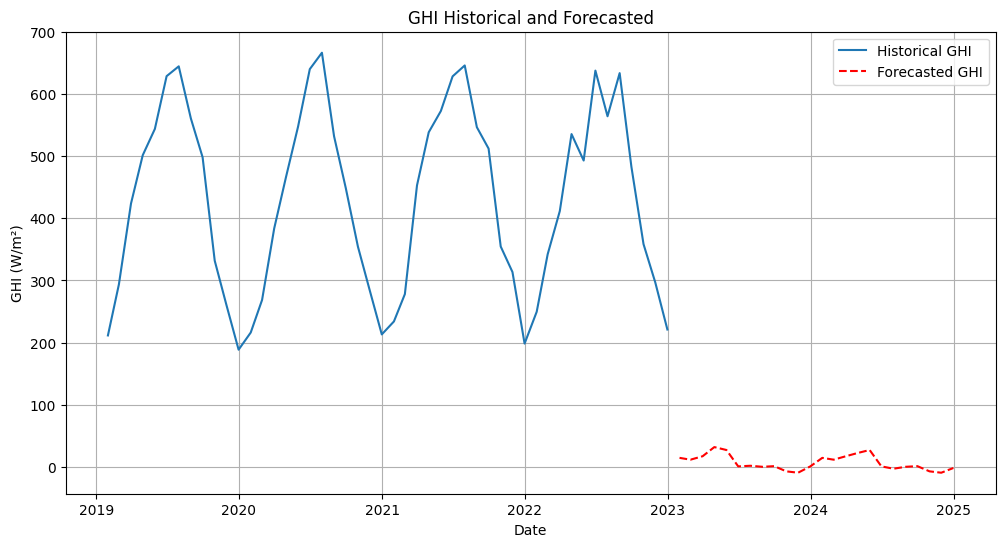

In [24]:
# Append the future predictions to the historical data for visualization
historical_data = monthly_data[['Date', 'Arlington GHI']]
future_data = future_df[['Date']].copy()
future_data['GHI'] = future_ghi  # Add forecasted GHI to the future data frame

# Concatenate historical and future data
full_data = pd.concat([historical_data, future_data], ignore_index=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(historical_data['Date'], historical_data['Arlington GHI'], label='Historical GHI')
plt.plot(future_data['Date'], future_data['GHI'], label='Forecasted GHI', linestyle='--', color='red')
plt.title('GHI Historical and Forecasted')
plt.xlabel('Date')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
tracker.stop()

0.0002576489701418707